In [1]:
import os,csv,json, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import SimpleITK as sitk
import tifffile as tif
import seaborn as sns
sys.path.append("../../src")


In [2]:


def points_resample(src, original_dims, resample_dims, verbose=False):
    """Function to adjust points given resizing by generating a transform matrix

    ***Assumes ZYX and that any orientation changes have already been done.***

    src: numpy array or list of np arrays of dims nx3
    original_dims (tuple)
    resample_dims (tuple)
    """
    src = np.asarray(src)
    assert src.shape[-1] == 3, "src must be a nx3 array"

    # initialize
    d1, d2 = src.shape
    nx4centers = np.ones((d1, d2+1))
    nx4centers[:, :-1] = src

    # acount for resampling by creating transformmatrix
    zr, yr, xr = resample_dims
    z, y, x = original_dims

    # apply scale diff
    trnsfrmmatrix = np.identity(4)*(zr/float(z), yr/float(y), xr/float(x), 1)
    if verbose:
        sys.stdout.write("trnsfrmmatrix:\n{}\n".format(trnsfrmmatrix))

    # nx4 * 4x4 to give transform
    trnsfmdpnts = nx4centers.dot(trnsfrmmatrix)  # z,y,x
    if verbose:
        sys.stdout.write("first three transformed pnts:\n{}\n".format(trnsfmdpnts[0:3]))

    return trnsfmdpnts



def transform_points(src, dst, transformfiles, resample_points=False):
    """

    Inputs
    ---------
    src = numpy file consiting of nx3 (ZYX points)
    dst = folder location to write points
    transformfiles =
        list of all elastix transform files used, and in order of the original transform****
    resample_points = [original_dims, resample_dims] if there was resampling done, use this here
    param_dictionary_for_reorientation = param_dictionary for lightsheet package to use for reorientation
    """
    # load
    cells = np.load(src)
    # optionally resample points
    if resample_points:
        original_dims, resample_dims = resample_points
        cells = points_resample(cells, original_dims, resample_dims)

    # generate text file
    pretransform_text_file = create_text_file_for_elastix(cells, dst)

    # copy over elastix files
    transformfiles = modify_transform_files(transformfiles, dst)

    # run transformix on points
    points_file = point_transformix(pretransform_text_file, transformfiles[-1], dst)

    # convert registered points into structure counts
    unpack_pnts(points_file, dst)

    return




def create_text_file_for_elastix(src, dst):
    """

    Inputs
    ---------
    src = numpy file consiting of nx3 (ZYX points)
    dst = folder location to write points
    """

    print("This function assumes ZYX centers...")

    # setup folder
    if not os.path.exists(dst):
        os.mkdir(dst)

    # create txt file, with elastix header, then populate points
    pth = os.path.join(dst, "zyx_points_pretransform.txt")

    # load
    if type(src) == np.ndarray:
        arr = src
    else:
        arr = np.load(src) if src[-3:] == "npy" else loadmat(src)["cell_centers_orig_coord"]

    # convert
    stringtowrite = "\n".join(["\n".join(["{} {} {}".format(i[0], i[1], i[2])])
                               for i in arr])

    # write file
    sys.stdout.write("writing centers to transfomix input points text file...")
    sys.stdout.flush()
    with open(pth, "w+") as fl:
        fl.write("index\n{}\n".format(len(arr)))
        fl.write(stringtowrite)
        fl.close()
    sys.stdout.write("...done writing centers\n")
    sys.stdout.flush()

    return pth


def modify_transform_files(transformfiles, dst):
    """Function to copy over transform files, modify paths in case registration was done on the cluster, and tether them together

        Inputs
    ---------
    transformfiles =
        list of all elastix transform files used, and in order of the original transform****

    """

    # new
    ntransformfiles = [os.path.join(dst, "order{}_{}".format(
        i, os.path.basename(xx))) for i, xx in enumerate(transformfiles)]

    # copy files over
    [shutil.copy(xx, ntransformfiles[i]) for i, xx in enumerate(transformfiles)]

    # modify each with the path
    for i, pth in enumerate(ntransformfiles):

        # skip first
        if i != 0:

            # read
            with open(pth, "r") as fl:
                lines = fl.readlines()
                fl.close()

            # copy
            nlines = lines

            # iterate
            for ii, line in enumerate(lines):
                if "(InitialTransformParametersFileName" in line:
                    nlines[ii] = "(InitialTransformParametersFileName {})\n".format(
                        ntransformfiles[i-1])

            # write
            with open(pth, "w") as fl:
                for nline in lines:
                    fl.write(str(nline))
                fl.close()

    return ntransformfiles


def point_transformix(pretransform_text_file, transformfile, dst):
    """apply elastix transform to points


    Inputs
    -------------
    pretransform_text_file = list of points that already have resizing transform
    transformfile = elastix transform file
    dst = folder

    Returns
    ---------------
    trnsfrm_out_file = pth to file containing post transformix points

    """
    sys.stdout.write("\n***********Starting Transformix***********")
    from subprocess import check_output
    # set paths
    trnsfrm_out_file = os.path.join(dst, "outputpoints.txt")

    # run transformix point transform
    call = "transformix -def {} -out {} -tp {}".format(pretransform_text_file, dst, transformfile)
    print(check_output(call, shell=True))
    sys.stdout.write("\n   Transformix File Generated: {}".format(trnsfrm_out_file))
    sys.stdout.flush()
    return trnsfrm_out_file



def get_transform_files_from_folder(transformfolder):
    transformfiles=[]
    for file in os.listdir(transformfolder):
        if "TransformParam" in file:
            print(file)
            transformfiles.append(os.path.join(transformfolder,file))
            transformfiles = transformfiles.sort()
    return transformfiles



def unpack_pnts(points_file, dst):
    """
    function to take elastix point transform file and return anatomical locations of those points

    Here elastix uses the xyz convention rather than the zyx numpy convention

    Inputs
    -----------
    points_file = post_transformed file, XYZ

    Returns
    -----------
    dst_fl = path to numpy array, ZYX

    """

    # inputs
    assert type(points_file) == str
    point_or_index = 'OutputPoint'

    # get points
    with open(points_file, "r") as f:
        lines = f.readlines()
        f.close()

    # populate post-transformed array of contour centers
    sys.stdout.write("\n\n{} points detected\n\n".format(len(lines)))
    arr = np.empty((len(lines), 3))
    for i in range(len(lines)):
        arr[i, ...] = lines[i].split()[lines[i].split().index(point_or_index) +
                                       3:lines[i].split().index(point_or_index)+6]  # x,y,z

    # optional save out of points
    dst_fl = os.path.join(dst, "posttransformed_zyx_voxels.npy")
    np.save(dst_fl, np.asarray([(z, y, x) for x, y, z in arr]))

    # check to see if any points where found
    print("output array shape {}".format(arr.shape))

    return dst_fl


In [3]:
basepath = "/home/emilyjanedennis/Desktop/e153/"
brainname = "e153_642_filt.npy"
brainpath = os.path.join(basepath,brainname)
#channel = "ch_488"
#filename = "_ch01_cells_filtered.npy"
#fullfilename = os.path.join(brainpath,filename)
fulldf = pd.DataFrame(np.load(brainpath))
outputfolder= os.path.join(basepath,"output_{}".format(brainname[:-4]))
#transformfolders = ["/home/emilyjanedennis/Desktop/j316/mPRA_to_j316_reg/",
#                   "/home/emilyjanedennis/Desktop/j316/j316_reg_to_j316_cell/"]

transformfolders = ["/home/emilyjanedennis/Desktop/e153/reg_to_cell/",
                   "/home/emilyjanedennis/Desktop/e153/atl_to_reg/"]

# SIGMA annotations 
annotation_volume_filename = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/SIGMA_annotations_in_mPRA.tif" 
annotation_labels = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/sigma_202107.csv"
annotation_volume = tif.imread(annotation_volume_filename)

#MRIr annotations 
#annotation_volume_filename= "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/WHS_SD_rat_T2star_v1.01_atlas.tif"
#annotation_labels = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/labels_v3.csv"
# see next cell for details!
# optional resampling between fullsized and input to elastix
#    ***Assumes ZYX and that any orientation changes have already been done.***
#original_dims = (606, 8701,7341) #zyx axial
#original_dims = (4124,10518,7580)

original_dims = (4470,8982,7640)
resample_dims = (865,1610,539)
#resample_dims = (591,1006,392) #zyx sagittal
#mPRA_dims=(618,1150,385)

#resample_dims= np.multiply(mPRA_dims,1).astype('int')
flipy = 0 #flip y if imaged upside down, true for all except _4x brains
switch_x_and_z = 1 #takes zyx points from full size axial data and turns them into sagittal
if switch_x_and_z: 
    original_dims = (original_dims[2],original_dims[1],original_dims[0])  

In [4]:
original_dims

(7341, 8701, 606)

### notes on orientations 

#### full size data is USUALLY but not always
    z planes: typically ~600, and going axially from  above -> below brain (e.g. 606)
    y = 8701 AP nose to cerebellum
    x = 7341 ML left to right
-- this is what CM2 sees (the _fullsizedata/ch00_ folder, for example)
    need to change the x and z axes 

#### then it's resampled for elastix to sagittal
    z = 591 left to right ML
    y = 1006 nose to cerebellum 
    x = 392 above to below
    
#### it could also be resized for elastix to be 140% of MRIr 
    z = 637 left to right ML
    y = 1084 nose to cerebellum
    x = 423 above to below

In [6]:
outputfolder

'/home/emilyjanedennis/Desktop/e153/output_e153_642_filt'

In [7]:
#only have to do once
os.mkdir(outputfolder)

In [8]:
fulldf = fulldf.apply(pd.to_numeric, errors='coerce')
fulldf

,x,y,z,size,source,background
0,51,6514,1561,6,306145.0,306145.0
1,52,6376,1561,8,307832.0,307832.0
2,52,6409,1561,26,307833.0,307833.0
3,52,6518,1561,7,307834.0,307834.0
4,53,6540,1561,17,309532.0,309532.0
...,...,...,...,...,...,...
631958,7631,6471,1258,38,66451584.0,66451584.0
631959,7631,6534,1258,9,66451586.0,66451586.0
631960,7631,6551,1258,100,66451587.0,66451587.0
631961,7631,6729,1258,34,66451589.0,66451589.0


In [9]:
if switch_x_and_z: 
    fulldf.columns = ['z','y','x','size','source','bkrd']

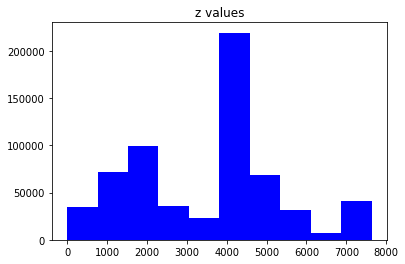

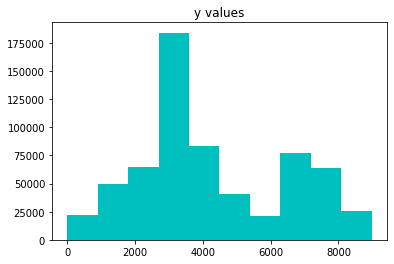

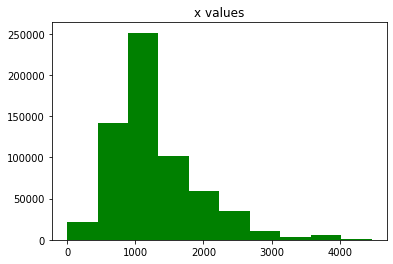

In [10]:
# plot summary data, helps make sure axes are correct and good to see 
subdf = fulldf[['z','y','x']]
npdf = subdf.to_numpy()


plt.hist(npdf[:,0],color='b')
plt.title('z values')
plt.show()
plt.hist(npdf[:,1],color='c')
plt.title('y values')
plt.show()
plt.hist(npdf[:,2],color='g')
plt.title('x values')
plt.show()

In [12]:
npdf_filename = "{}{}_pdf.npy".format(os.path.join(outputfolder,"a253"),"488")
npdf_filename
np.save(npdf_filename,npdf)


In [33]:
npdf_filename

'/home/emilyjanedennis/Desktop/e153/output_e153_642_filt/a253488_pdf.npy'

In [23]:
resample_points = [original_dims, resample_dims]


transformfiles = get_transform_files_from_folder(transformfolders[0])
transform_points(npdf_filename,outputfolder,transformfiles,resample_points)


TransformParameters.0.txt
This function assumes ZYX centers...
writing centers to transfomix input points text file......done writing centers

***********Starting Transformix***********b'\ntransformix is started at Mon Jul 19 13:50:49 2021.\n\nwhich transformix:   transformix\ntransformix runs at: emilyjanedennis-linux\n  Linux 5.8.0-48-generic (x64), #54~20.04.1-Ubuntu SMP Sat Mar 20 13:40:25 UTC 2021\n  with 128512 MB memory, and 10 cores @ 2695 MHz.\nRunning transformix with parameter file "/home/emilyjanedennis/Desktop/e153/output_e153_642_filt/order0_TransformParameters.0.txt".\n\nReading the elastix parameters from file ...\n\nInstalling all components.\nInstallingComponents was successful.\n\nELASTIX version: 5.000\nCommand line options from ElastixBase:\n-in       unspecified, so no input image specified\n-out      /home/emilyjanedennis/Desktop/e153/output_e153_642_filt/\n-threads  unspecified, so all available threads are used\n-tp       /home/emilyjanedennis/Desktop/e153/outp

In [39]:
transformfolders

['/home/emilyjanedennis/Desktop/e153/reg_to_cell/',
 '/home/emilyjanedennis/Desktop/e153/atl_to_reg/']

In [45]:
#os.rename('/home/emilyjanedennis/Desktop/e153/output_e153_642_filt/posttransformed_zyx_voxels.npy','/home/emilyjanedennis/Desktop/e153/output_e153_642_filt/posttransformed_zyx_voxels_REG_TO_CELL.npy')
renamed_filename = '/home/emilyjanedennis/Desktop/e153/output_e153_642_filt/posttransformed_zyx_voxels_REG_TO_CELL.npy'
transformfiles = get_transform_files_from_folder(transformfolders[1])
transformfiles.sort()
transformfiles

TransformParameters.1.txt
TransformParameters.0.txt
TransformParameters.2.txt
TransformParameters.3.txt


['/home/emilyjanedennis/Desktop/e153/atl_to_reg/TransformParameters.0.txt',
 '/home/emilyjanedennis/Desktop/e153/atl_to_reg/TransformParameters.1.txt',
 '/home/emilyjanedennis/Desktop/e153/atl_to_reg/TransformParameters.2.txt',
 '/home/emilyjanedennis/Desktop/e153/atl_to_reg/TransformParameters.3.txt']

In [79]:
resample_points = [resample_dims, tuple(np.multiply(resample_dims,0.7).astype('int'))]

# if doesn't work, try second resample_dims == 1.4x resample_dims
transform_points(renamed_filename,outputfolder,transformfiles)


This function assumes ZYX centers...
writing centers to transfomix input points text file......done writing centers

***********Starting Transformix***********b'\ntransformix is started at Mon Jul 19 17:25:11 2021.\n\nwhich transformix:   transformix\ntransformix runs at: emilyjanedennis-linux\n  Linux 5.8.0-48-generic (x64), #54~20.04.1-Ubuntu SMP Sat Mar 20 13:40:25 UTC 2021\n  with 128512 MB memory, and 10 cores @ 1199 MHz.\nRunning transformix with parameter file "/home/emilyjanedennis/Desktop/e153/output_e153_642_filt/order3_TransformParameters.3.txt".\n\nReading the elastix parameters from file ...\n\nInstalling all components.\nInstallingComponents was successful.\n\nELASTIX version: 5.000\nCommand line options from ElastixBase:\n-in       unspecified, so no input image specified\n-out      /home/emilyjanedennis/Desktop/e153/output_e153_642_filt/\n-threads  unspecified, so all available threads are used\n-tp       /home/emilyjanedennis/Desktop/e153/output_e153_642_filt/order3_Tr

In [80]:
test = np.load('/home/emilyjanedennis/Desktop/e153/output_e153_642_filt/posttransformed_zyx_voxels.npy')
columns = list(zip(*test))

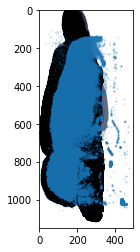

In [84]:
plt.imshow(np.amax(annotation_volume,0),cmap='bone_r', vmin=0, vmax=255)
plt.scatter(columns[2],columns[1],alpha=0.1,s=1)
plt.show()

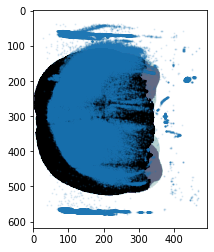

In [87]:
plt.imshow(np.amax(annotation_volume,1),cmap='bone_r', vmin=0, vmax=255)
plt.scatter(columns[2],columns[0],alpha=0.1,s=1)
plt.show()

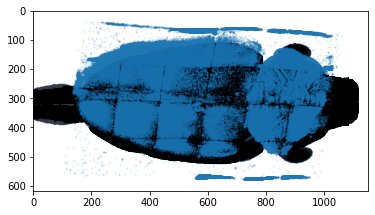

In [86]:
plt.imshow(np.amax(annotation_volume,2),cmap='bone_r', vmin=0, vmax=255)
plt.scatter(columns[1],columns[0],alpha=0.1,s=1)
plt.show()

In [47]:
x = np.zeros(np.shape(annotation_volume))
x=np.zeros(resample_dims)

In [26]:
xs=[]
ys=[]
zs=[]
for cell in test:
    zs.append(cell.astype('int')[0])
    ys.append(cell.astype('int')[1])
    xs.append(cell.astype('int')[2])

In [27]:
np.max(xs)

374

In [28]:
np.max(ys)

1038

In [29]:
np.max(zs)

393

In [19]:
for cell in trnsfmdpnts:
    print([cell.astype('int')[0],cell.astype('int')[1],cell.astype('int')[2]])
    x[cell.astype('int')[0],cell.astype('int')[1],cell.astype('int')[2]]=1
    

NameError: name 'trnsfmdpnts' is not defined

In [95]:
tif.imsave('/home/emilyjanedennis/Desktop/test.tif',x)

In [55]:
transformed[30000].astype('int')[0]

130

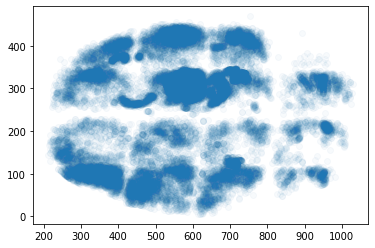

In [14]:
plt.scatter(transformed[:,1],transformed[:,2],alpha=0.03)
plt.show()

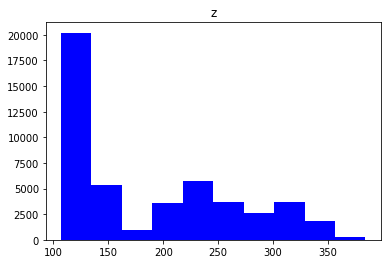

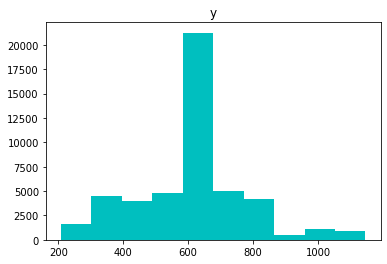

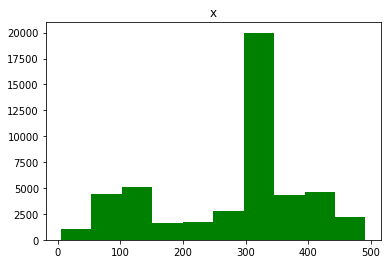

In [55]:
plt.hist(transformed[:,0],color='b')
plt.title("z")
plt.show()
plt.hist(transformed[:,1],color='c')
plt.title("y")
plt.show()
plt.hist(transformed[:,2],color='g')
plt.title("x")
plt.show()

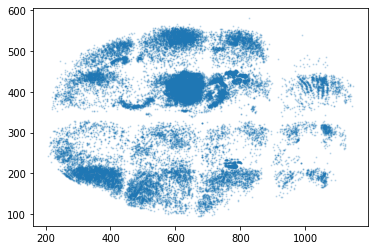

In [56]:
plt.scatter(transformed[:,1],transformed[:,2]+90,s=1,alpha=0.2)
plt.show()

In [352]:
floort = np.floor(transformed)

In [353]:
masked_data = np.zeros(np.shape(annotation_volume))
np.shape(floort)

(47939, 3)

In [889]:
floortcopy=floort
np.max(floortcopy[:,0])

271.0

In [890]:
floort[:,1]=50+floort[:,1]
floort=floort[floort[:,0]<454]
floort=floort[floort[:,1]<773]
floort=floort[floort[:,2]<301]
floort=floort[floort[:,0]>0]
floort=floort[floort[:,1]>0]
floort=floort[floort[:,2]>0]

In [891]:
# for each row in transformed, place the value in edgevent in the correct space
for i in np.arange(0,np.shape(floort)[0]-1):
    x,y,z=floort[i,:]
    z=z.astype(int)
    y=y.astype(int)
    x=x.astype(int)
    if annotation_volume[x,y,z]>0:
        masked_data[x,y,z] = annotation_volume[x,y,z]

In [892]:
tif.imsave(os.path.join(brainpath,"{}_{}_eroded_results.tif".format(brainname,channel)),masked_data)

In [893]:
reshaped_masked=masked_data.reshape(np.size(masked_data),1)
np.shape(reshaped_masked)

(106355340, 1)

In [894]:
reshaped_masked=reshaped_masked[reshaped_masked>0]
max_masked = np.max(reshaped_masked)

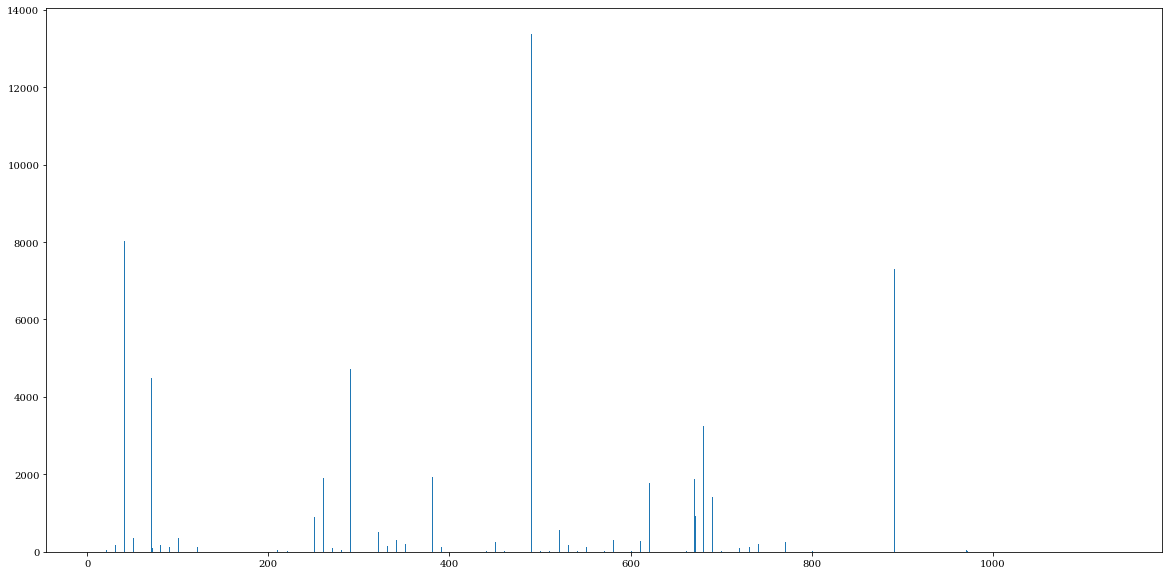

In [895]:
histinfo =plt.hist(reshaped_masked,bins=max_masked.astype(int))
plt.show()

In [896]:
labels.insert(3,'histinfo',0)

In [897]:
labels

,atlas,ID,label,histinfo
0,SIGMA,1171,Ventricular System,0
1,Waxholm,171,Globus Pallidus,0
2,Waxholm,731,Striatum,0
3,Waxholm,221,Granule Cell Level of the Cerebellum,0
4,Waxholm,341,Molecular Layer of the Cerebellum,0
...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,0
230,Waxholm,902,Deeper Layers of the Superior Colliculus,0
231,Waxholm,1082,SP5,0
232,Waxholm,792,Anterior Commissure Intrabulbar part,0


In [898]:
for i in np.arange(1,max_masked.astype(int)):
    labels.histinfo[labels.ID==i]=histinfo[0][i]

/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [899]:
#calculating sigma info

In [900]:
annotation_volume_filename

'/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/SIGMA_annotation_50um_edge_50um_vent_erosion.tif'

In [901]:
np.shape(annotation_volume)

(455, 774, 302)

In [902]:
labels.insert(4,'vx_in_annotated_volume',0)

In [903]:
for i in labels.ID:
    labels.vx_in_annotated_volume[labels.index[labels.ID == i]] = np.size([annotation_volume[annotation_volume==i]])

/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [904]:
totalcellcount = np.sum(labels.histinfo)

In [905]:
labels.insert(4,'percent_of_cells',0)
labels.insert(5,'percent_of_voxels',0)

In [906]:
for i in labels.index:
    labels.percent_of_cells[i] = 100*(labels.histinfo[i]/totalcellcount)
    labels.percent_of_voxels[i] = 100*(labels.histinfo[i]/labels.vx_in_annotated_volume[i])

/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/emilyjanedennis/anaconda3/envs/lightsheet/lib/python3.7/site-

In [907]:
labels

,atlas,ID,label,histinfo,percent_of_cells,percent_of_voxels,vx_in_annotated_volume
0,SIGMA,1171,Ventricular System,0,0,NaN,0
1,Waxholm,171,Globus Pallidus,0,0,0.0,1867
2,Waxholm,731,Striatum,0,0,0.0,907108
3,Waxholm,221,Granule Cell Level of the Cerebellum,0,0,0.0,676465
4,Waxholm,341,Molecular Layer of the Cerebellum,0,0,0.0,2320922
...,...,...,...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,0,0,0.0,1641
230,Waxholm,902,Deeper Layers of the Superior Colliculus,0,0,0.0,262212
231,Waxholm,1082,SP5,0,0,0.0,14276
232,Waxholm,792,Anterior Commissure Intrabulbar part,0,0,0.0,25390


In [908]:
csvname = os.path.join(brainpath,"{}_{}_counts_SIGMA_50eroded.csv".format(brainname,channel))
labels.to_csv(csvname)

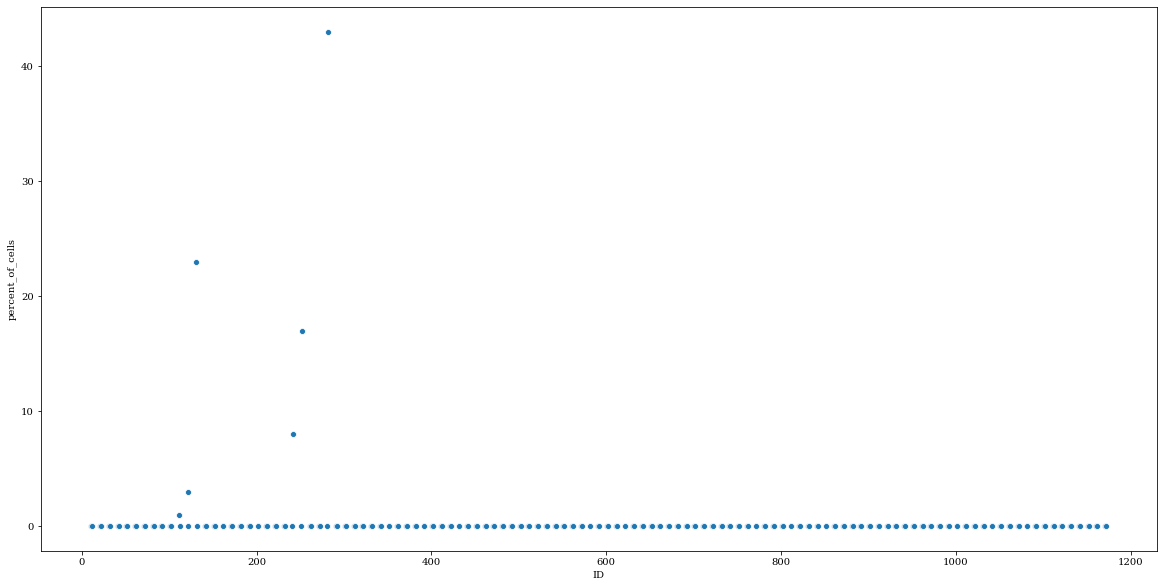

In [909]:
ax = sns.scatterplot(x='ID',y='percent_of_cells',data=labels)
plt.show()

In [51]:
cell_in_atl = pd.DataFrame(np.load('/home/emilyjanedennis/Desktop/testing/j316_cell_in_atl_transform_zyx_voxels.npy'))

In [52]:
cell_in_reg = pd.DataFrame(np.load('/home/emilyjanedennis/Desktop/testing/j316_cell_in_reg_posttransform_zyx_voxels.npy'))

In [53]:
reg_in_atl = pd.DataFrame(np.load('/home/emilyjanedennis/Desktop/testing/j316_reg_in_atl_transform_zyx_voxels.npy'))

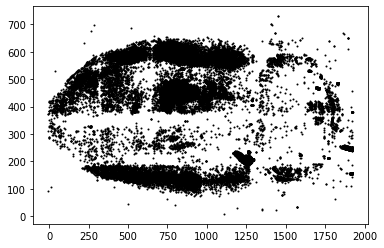

In [55]:
plt.scatter(cell_in_reg[1],cell_in_reg[0],s=1,c='k')
plt.show()

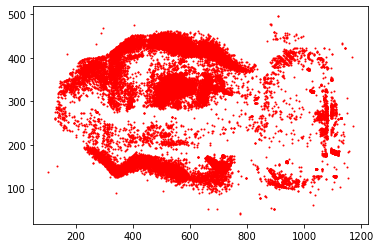

In [56]:
plt.scatter(cell_in_atl[1],cell_in_atl[0],s=1,c='r')